In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# install the requirements
!pip install -r pip_requirements.txt

In [4]:
import pandas as pd
from collections import Counter
import ast
from src.scripts.cmu_scripts import *


# Cleaning the CMU dataset
First of all, we need to pre-process the CMU dataset in order to have cleaned data to process.

### Load the data

In [5]:
# We begin by loading the data
DATAPATH = "src/data/"
movies_df = load_tsv(DATAPATH + "movie.metadata.tsv")
characters_df = load_tsv(DATAPATH + "character.metadata.tsv")

### Filter and name

We see that the Dataframes have a lot of columns which are not always useful. In addition, they do not have a name. So let's begin by giving a name to those columns and filtering those we do not need.

In [6]:
# We name the columns and pick which ones we want
movies_df, characters_df = name_and_filter_columns(movies_df, characters_df)

It is really important to track the NaN values in the dataset, so let's print the info we have on each column.

Total entries: 81741

Freebase movie ID        0
Movie name               0
Movie release date    6902
Movie countries          0
Movie genres             0
dtype: int64


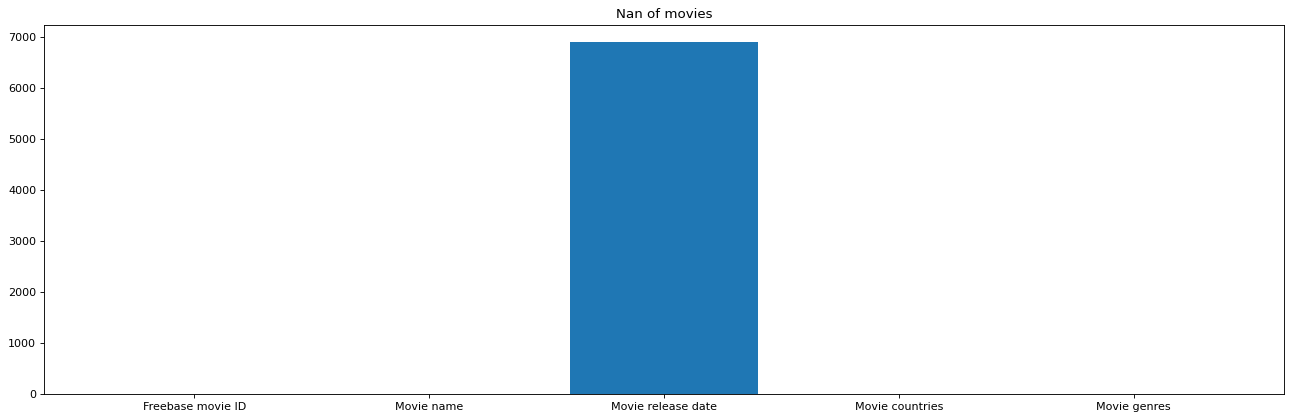

________________________
Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106145
Actor gender                   45609
Actor name                      1228
Actor age at movie release    158113
Freebase character ID         257865
Freebase actor ID                815
dtype: int64


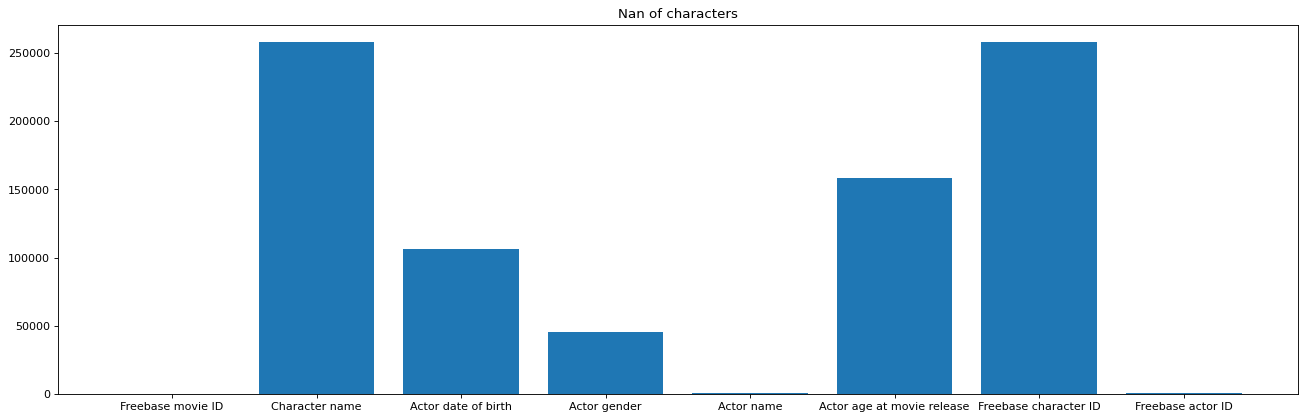

In [7]:
# We print some info about NaNs
plot_nan_values(movies_df, "Nan of movies")
plt.show()
print("________________________")
plot_nan_values(characters_df, "Nan of characters")
plt.show()

Let's see also how is the data.

In [8]:
movies_df.head()

,Freebase movie ID,Movie name,Movie release date,Movie countries,Movie genres
0,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,/m/0crgdbh,Brun bitter,1988,"{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,/m/0285_cd,White Of The Eye,1987,"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,/m/01mrr1,A Woman in Flames,1983,"{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [9]:
characters_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID
0,/m/03vyhn,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7
1,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4
2,/m/03vyhn,Desolation Williams,1969-06-15,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l
3,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,Jason Statham,33.0,/m/0bgchnq,/m/034hyc
4,/m/03vyhn,Bashira Kincaid,1977-09-25,F,Clea DuVall,23.0,/m/0bgchp9,/m/01y9xg


#### Analyze
We see that the data is OK, but there are some problems. Firstly, the Freebase IDs are obsolete, so we cannot retrieve any information from that. However, it can link the two tables and serve as an indices. We will therefor keep some. Secondly, the dates are awful. Somtimes in the format 'YYYY-MM-DD' sometimes 'YYYY' or NaN and always in string. Third, the actor age are float but we can consider it as int. Finally, the 'Movie countries' and 'Movie Genres' columns are stored as a "string dict" with a Freebase ID as an index. It cannot be used as this.

### Reformat and type fixing

We saw that the 'Movie countries' and 'Movie genres' have a strange format. It includes a Freebase id and its real value. Let's fix this by converting the string dict to a list of the real values.

In [10]:
#We transform the movie genres and countries from a string dict to a list
movies_df = refactor_movie_genres_countries(movies_df)
movies_df[['Movie countries', 'Movie genres']].head()

,Movie countries,Movie genres
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,[Norway],"[Crime Fiction, Drama]"
3,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,[Germany],[Drama]


We also see that the dates do not all have the same format and have absurd values (like year 1000). Let's change this by taking only the year of the date,casting it to `int` and change all absurd values by NaN. (N.B. this may be tricky since these columns contains NaN values). 

In [11]:
# We refactor the release date (take only the year and cast to int)
movies_df = refactor_movie_release_date(movies_df)
movies_df['Movie release date'].head()

0    2001
1    2000
2    1988
3    1987
4    1983
Name: Movie release date, dtype: Int64

In [12]:
# We do the same with the date of birth
characters_df = refactor_actor_dob(characters_df)
characters_df['Actor date of birth'].head()

0    1958
1    1974
2    1969
3    1967
4    1977
Name: Actor date of birth, dtype: Int64

Then, we see that the 'Actor age at movie release' column is in float, while it logically must contain only integer values. We can just cast it.

In [13]:
print(type(characters_df['Actor age at movie release'][7]))

<class 'numpy.float64'>


In [14]:
# We cast actor age to int
characters_df['Actor age at movie release'] = characters_df['Actor age at movie release'].astype('Int64')
characters_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID
0,/m/03vyhn,Akooshay,1958,F,Wanda De Jesus,42,/m/0bgcj3x,/m/03wcfv7
1,/m/03vyhn,Lieutenant Melanie Ballard,1974,F,Natasha Henstridge,27,/m/0bgchn4,/m/0346l4
2,/m/03vyhn,Desolation Williams,1969,M,Ice Cube,32,/m/0bgchn_,/m/01vw26l
3,/m/03vyhn,Sgt Jericho Butler,1967,M,Jason Statham,33,/m/0bgchnq,/m/034hyc
4,/m/03vyhn,Bashira Kincaid,1977,F,Clea DuVall,23,/m/0bgchp9,/m/01y9xg


We have seen that their is some countries in the dataset that no more longer exist (West germany , URSS for example). We have craete a dictionary defined in 'clean_country.py' to clean theses countries.

In [15]:
# clean the countries
from src.utils.clean_country import country_mapping
movies_df['Movie countries'] = movies_df['Movie countries'].apply(lambda x: [country_mapping.get(elem) for elem in x])
# remove duplicate in list (like west and est germany)
movies_df['Movie countries'] = movies_df['Movie countries'].apply(lambda x: list(set(x)))

### Joining the Dataframes
Now that we have corrected the values, we can join the two Dataframes in order to have all information on one big Dataframe.

In [16]:
# We join the two dataframes
joined_df = characters_df.join(movies_df.set_index('Freebase movie ID'), on='Freebase movie ID', how='left')

In [17]:
joined_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID,Movie name,Movie release date,Movie countries,Movie genres
0,/m/03vyhn,Akooshay,1958,F,Wanda De Jesus,42,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
1,/m/03vyhn,Lieutenant Melanie Ballard,1974,F,Natasha Henstridge,27,/m/0bgchn4,/m/0346l4,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
2,/m/03vyhn,Desolation Williams,1969,M,Ice Cube,32,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
3,/m/03vyhn,Sgt Jericho Butler,1967,M,Jason Statham,33,/m/0bgchnq,/m/034hyc,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
4,/m/03vyhn,Bashira Kincaid,1977,F,Clea DuVall,23,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."


Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106170
Actor gender                   45609
Actor name                      1228
Actor age at movie release    158113
Freebase character ID         257865
Freebase actor ID                815
Movie name                         0
Movie release date             10010
Movie countries                    0
Movie genres                       0
dtype: int64


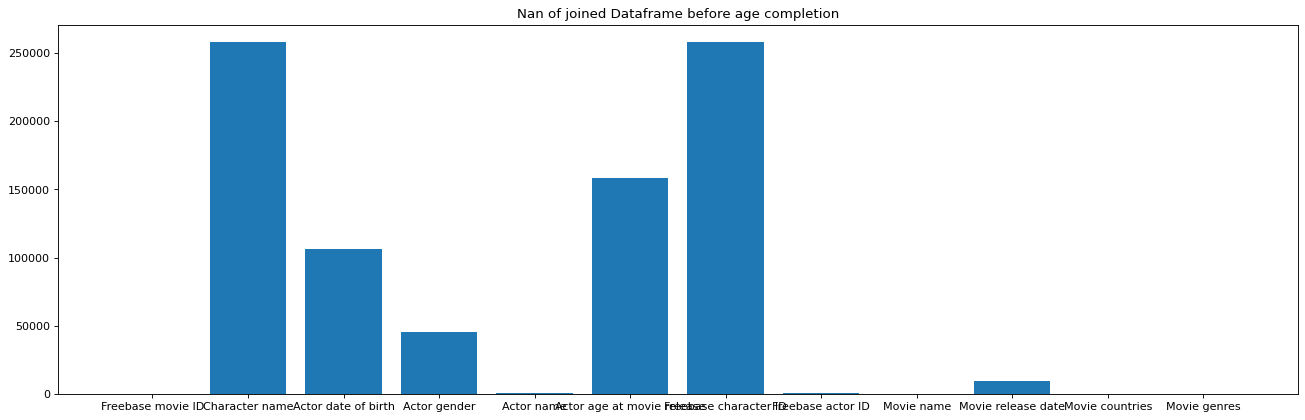

In [18]:
plot_nan_values(joined_df, "Nan of joined Dataframe before age completion")
plt.show()

### Age completion

A lot of ages at movie release are still missing. Since we know the date of birth and the movie release date, we can easily deduce the actor age at movie release. Let's do that.
As we do not need the date of birth and the movie release date, we can just remove them.

Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106170
Actor gender                   45609
Actor name                      1228
Actor age at movie release    115273
Freebase character ID         257865
Freebase actor ID                815
Movie name                         0
Movie release date             10010
Movie countries                    0
Movie genres                       0
dtype: int64


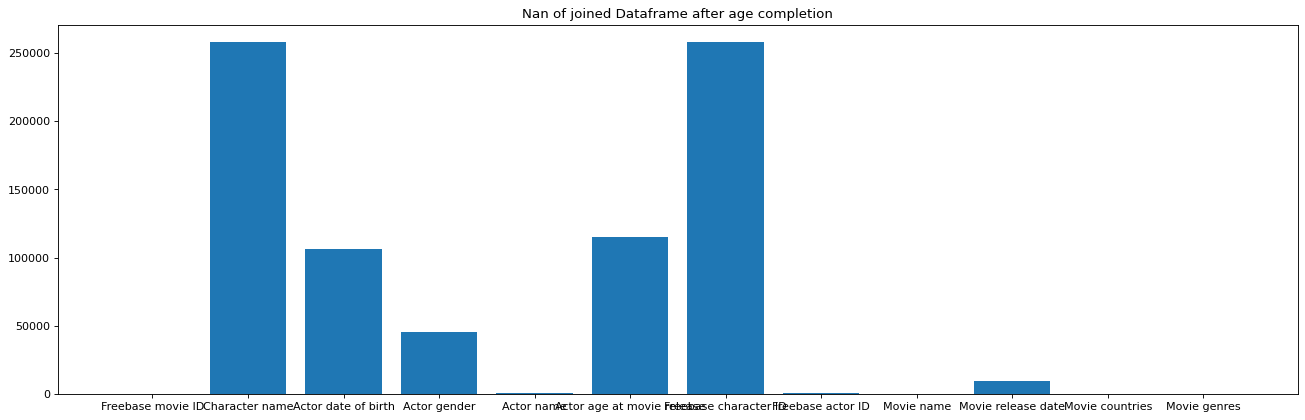

In [19]:
preprocessed_df = complete_age(joined_df)
plot_nan_values(joined_df, "Nan of joined Dataframe after age completion")

(N.B. If we still need more data, we can complete the age of the actors by looking on another database like Wikidata)

# Q1
An important part of our project is to link actors with their career path. We defined the career path as a chronological list the personas of all characters he played.
We can split this task in two steps:
- link characters to their personas
- link actor to their personas using the fact that the metadata contains character names.

## link characters to their personas
To do this, we extracted characters and their personas from the movies summaries. We did this using the ``gpt4o mini`` model, prompting it to extract characters and their personas of each summary. We currently only computed this for the first 9000 summaries of the ``plot_summaries.txt``, but the rest can be computed in 4 days (not doable faster than 10000 documents a day due to API limitations).

In [20]:
pd.read_pickle('src/data/processed_data0-9000.pkl')

,name,persona,wikipedia_id
0,Shlykov,[the warrior],23890098
1,Lyosha,"[the rebel, the lover]",23890098
0,Katniss Everdeen,"[the warrior, the caregiver, the rebel]",31186339
1,Peeta Mellark,"[the lover, the caregiver, the seducer]",31186339
2,Primrose Everdeen,"[the child, the orphan]",31186339
...,...,...,...
4,The Chief of Police,"[the ruler, the mentor]",6183117
0,Noah Arkwright,"[the rebel, the creator, the lover]",10572926
1,Kirstin,"[the caregiver, the mentor]",10572926
2,Ray,"[the joker, the caregiver]",10572926


then we can link the personas with the cator who played them using the character name and the wikipedia movie id.

In [21]:
career_paths = pd.read_pickle('src/data/careers_paths.pkl')
career_paths

,personas_list,actor_age_during_movies,wikipedia_movies_id,freebase_actor_id
actor_name,,,,
A Martinez,"[[the mentor, the warrior]]",[62.0],[30231661],/m/025rrt9
A. J. Cook,"[[the lover], [the orphan, the caregiver, the ...","[22.0, 23.0]","[1376896, 12256764]",/m/02zyvw
Aamir Khan,"[[the rebel], [the rebel, the caregiver]]","[20.0, 25.0]","[8153108, 3322205]",/m/015npr
Aaron Aziz,"[[the ruler, the magician]]",[32.0],[16345566],/m/0j9mvdl
Aaron Eckhart,"[[the detective, the caregiver], [the caregive...","[32.0, 37.0, 43.0]","[1354757, 19189562, 12580152]",/m/03t4cz
...,...,...,...,...
Zoë Kravitz,"[[the caregiver, the lover], [the caregiver, t...","[21.0, 21.0, nan]","[29545870, 29545870, 27686452]",/m/03c144k
Zsa Zsa Gábor,"[[the caregiver, the creator], [the seducer, t...","[75.0, nan]","[4832313, 10099627]",/m/013ybx
Zuzana Fialová,[[the lover]],[32.0],[18555435],/m/0cr7m2r


In [22]:
#career path example
path_example = career_paths[career_paths.index=='Harrison Ford']

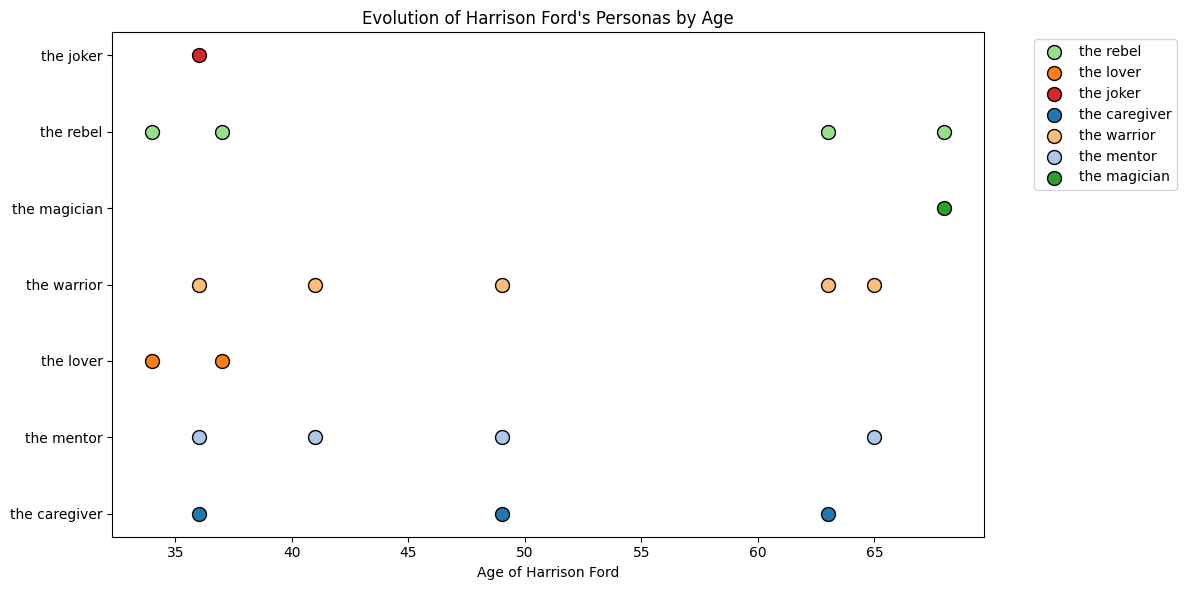

In [23]:
# visualise the path as personas played given the actor age
import matplotlib.pyplot as plt

# Data
personas = path_example['personas_list'].item()
ages = path_example['actor_age_during_movies'].item()

# Flatten data into persona-age pairs for easier plotting
persona_age_pairs = [(age, persona) for age, persona_list in zip(ages, personas) for persona in persona_list]

# Unique personas for color mapping
unique_personas = list(set(persona for _, persona in persona_age_pairs))

# Color mapping for personas
color_map = {persona: plt.cm.tab20(i) for i, persona in enumerate(unique_personas)}

# Plotting
plt.figure(figsize=(12, 6))
for age, persona in persona_age_pairs:
    plt.scatter(age, unique_personas.index(persona), color=color_map[persona], label=persona, s=100, edgecolor="black")

# Axis setup
plt.yticks(range(len(unique_personas)), unique_personas)
plt.xlabel("Age of Harrison Ford")
plt.title("Evolution of Harrison Ford's Personas by Age")

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels in legend
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Extract informations on the actors and on the characters

We firstly extracted all the information needed (actor name, character name, freebase actor id, freebase character id) frm the character's metadata of the CMU dataset.

In [24]:
# select the relevant columns
df_character_usefull = preprocessed_df[['Character name', 'Actor name', 'Freebase character ID', 'Freebase actor ID']]

We fisrtly create a util `wikidata_ID_retriever` for trying to get a wikidata ID from a freebase ID. Since all the freebase ID are not necessary present in the wikidata dataset.

In [25]:
# import the util class to convert wikidata ID to freebase ID.
from src.utils.wikidata_ID_retriever import WikidataIDRetriever

wikidataIDRetriever = WikidataIDRetriever()
# freebase ID to test
freebaseID = '/m/0c0k1'
# wikidata ID retrive
wikiDataID = wikidataIDRetriever.retrieve_wikidata_ID(freebaseID)
wikiDataID

'Q81328'

Then we create a util `wikidata_actor_loader`to retrieve all the actors information if an actor is present on the wikidata dataset with his freebase ID defined. 

In [26]:
# extract the list of actor's freebase id and drop the duplicates
actor_freebase_id = df_character_usefull['Freebase actor ID'].drop_duplicates()
print(f"Number of actor freebase IDs on CMU : {len(actor_freebase_id)}")
# import the data loader relative to the actor
from src.utils.wikidata_actor_loader import WikiDataActorLoader
actor_data_loader = WikiDataActorLoader()
# (uncomment to lunch the loading and save the result in a csv)
# actor_data_loader.load_wikidata(fileName='src/data/wikidata_actors_not_clean', freebase_IDs=actor_freebase_id)
# (uncomment to clean the data retrived previously and save them ionto a new csv file.)
# actor_data_loader.clean_file_data(fileName='src/data/wikidata_actors_not_clean.csv', newFileName='src/data/wikidata_actors_clean')
# load the clean version of wikidata information extracted
actor_wikidata = pd.read_csv('src/data/wikidata_actors_clean.csv')
print(f"Number of actor wikidata exctracted : {actor_wikidata.shape[0]}")
actor_wikidata.head(10)


Number of actor freebase IDs on CMU : 135761
Number of actor wikidata exctracted : 52806


,actor,actorLabel,birth_date,death_date,gender,imdb_id,freebase_id,nationality,occupation,spouse,children,alma_mater,award_received,wikidata_id
0,http://www.wikidata.org/entity/Q173637,Ice Cube,1969-06-15T00:00:00Z,NaN,male,nm0001084,/m/01vw26l,['United States'],"['rapper', 'songwriter', 'record producer', 't...",[],"[""O'Shea Jackson Jr.""]","['William Howard Taft Charter High School', 'W...","['star on Hollywood Walk of Fame', 'Ice Cube I...",Q173637
1,http://www.wikidata.org/entity/Q175900,Meiko Kaji,1947-03-24T00:00:00Z,NaN,female,nm0435299,/m/0576kw,['Japan'],"['musician', 'singer', 'actor']",[],[],[],"['Mainichi Film Award for Best Actress', 'Blue...",Q175900
2,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,/m/0h1_w,['United States'],"['film actor', 'television actor', 'character ...","['Ellis Baker', 'Florence Eldridge']",[],"['Washington Park High School', 'University of...","['star on Hollywood Walk of Fame', 'Tony Award...",Q181819
3,http://www.wikidata.org/entity/Q185051,Christopher Walken,1943-03-31T00:00:00Z,NaN,male,nm0000686,/m/016fjj,['United States'],"['film actor', 'television actor', 'model', 'd...",['Georgianne Walken'],[],"['Hofstra University', ""Professional Children'...","['Sitges Grand Honorary Award', 'Theatre World...",Q185051
4,http://www.wikidata.org/entity/Q67881,Hanns Zischler,1947-06-18T00:00:00Z,NaN,male,nm0957193,/m/09k3x_,['Germany'],"['essayist', 'film actor', 'television actor',...",[],[],[],['Cross of the Order of Merit of the Federal R...,Q67881
5,http://www.wikidata.org/entity/Q68054,Gudrun Landgrebe,1950-06-20T00:00:00Z,NaN,female,nm0484727,/m/09d6hv,['Germany'],"['film actor', 'stage actor', 'actor']",[],[],['Schauspielschule Der Keller'],['Askania Award'],Q68054
6,http://www.wikidata.org/entity/Q136646,ZaSu Pitts,1894-01-03T00:00:00Z,1963-06-07T00:00:00Z,female,nm0686032,/m/01lr4p,['United States'],"['film actor', 'television actor', 'stage acto...",['Tom Gallery'],[],['Santa Cruz High School'],['star on Hollywood Walk of Fame'],Q136646
7,http://www.wikidata.org/entity/Q169963,Jason Statham,1967-07-26T00:00:00Z,NaN,male,nm0005458,/m/034hyc,['United Kingdom'],"['competitive diver', 'kickboxer', 'martial ar...",[],[],[],[],Q169963
8,http://www.wikidata.org/entity/Q186757,Seth Green,1974-02-08T00:00:00Z,NaN,male,nm0001293,/m/0gz5hs,['United States'],"['television writer', 'film actor', 'televisio...",['Clare Grant'],[],[],[],Q186757
9,http://www.wikidata.org/entity/Q188772,Willem Dafoe,1955-07-22T00:00:00Z,NaN,male,nm0000353,/m/01f7dd,['United States'],"['film actor', 'model', 'film producer', 'stag...",['Giada Colagrande'],[],"['University of Wisconsin–Milwaukee', 'Appleto...","[""Romics d'Oro"", 'Volpi Cup for Best Actor', '...",Q188772


The ocupation field for each actor can be used to answer Q1, the graph bellow show the distrubutions of the actor occupations.

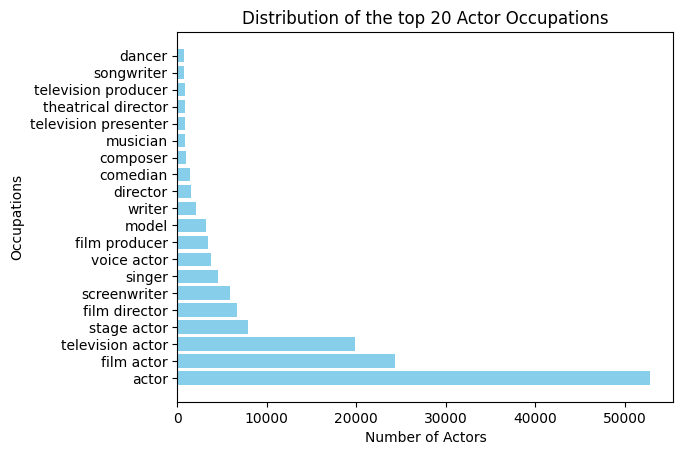

In [27]:
# convert occupation to list
actor_wikidata['occupation'] = actor_wikidata['occupation'].apply(ast.literal_eval)

# retrive all the actor's occupation and count their occurences
occupations_lst = [occupation for interOccupationLst in actor_wikidata['occupation'].dropna() for occupation in interOccupationLst]
occupation_count = Counter(occupations_lst)

# create a dataframe to create the graph
df_actor_occupation = pd.DataFrame(occupation_count.items(), columns=['Occupation', 'Count'])
# sortby count and only select the first 20 items for readibility of the graph
df_actor_occupation = df_actor_occupation.sort_values(by='Count', ascending=False).head(20)

# constrcut the graph 
plt.barh(df_actor_occupation['Occupation'], df_actor_occupation['Count'], color='skyblue')
plt.xlabel('Number of Actors')
plt.ylabel('Occupations')
plt.title('Distribution of the top 20 Actor Occupations')
plt.show()

We also create a util `wikidata_actor_loader`to retrieve all the characters information if a character is present on the wikidata dataset with his freebase ID defined. 

In [28]:
# extract the list of character's freebase id and drop the duplicates
character_freebase_id = df_character_usefull['Freebase character ID'].drop_duplicates()
print(f"Number of character freebase IDs on CMU : {len(character_freebase_id)}")
# import the data loader relative to the character
from src.utils.wikidata_character_loader import WikiDataCharacterLoader
character_data_loader = WikiDataActorLoader()
# (uncomment to lunch the loading and save the result in a csv)
# character_data_loader.load_wikidata(fileName='src/data/wikidata_characters_not_clean', freebase_IDs=character_freebase_id)
# (uncomment to clean the data retrieved previously and save them into a new csv file.)
#character_data_loader.clean_file_data(fileName='src/data/wikidata_characters_not_clean.csv', newFileName='src/data/wikidata_characters_clean')
# load the clean version of wikidata information extracted
character_wikidata = pd.read_csv('src/data/wikidata_characters_clean.csv')
print(f"Number of characters wikidata exctracted : {character_wikidata.shape[0]}")
character_wikidata.head(10)

Number of character freebase IDs on CMU : 183436
Number of characters wikidata exctracted : 2873


,character,characterLabel,freebase_id,occupation,affiliation,allies,wikidata_id
0,http://www.wikidata.org/entity/Q2975734,Keyser Söze,/m/03z0qw,"['drug trafficker', 'drug lord', 'con artist']",NaN,NaN,Q2975734
1,http://www.wikidata.org/entity/Q694790,Lex Luthor,/m/04q78,"['philanthropist', 'mass murderer', 'drug traf...","['Intergang', 'Injustice League', 'LCorp', 'Se...","['Lex Luthor', 'Jr.', 'Jaxon Xavier', 'Conner ...",Q694790
2,http://www.wikidata.org/entity/Q867810,Clark Kent,/m/02362,['reporter'],"['Daily Star', 'Daily Planet']",NaN,Q867810
3,http://www.wikidata.org/entity/Q1033152,RoboCop,/m/0h3w0g,['police officer'],NaN,NaN,Q1033152
4,http://www.wikidata.org/entity/Q2260732,General Zod,/m/03jlpc,"['soldier', 'leader']","['Superman Revenge Squad', 'Suicide Squad']",['Chris Kent'],Q2260732
5,http://www.wikidata.org/entity/Q58363586,narrator,/m/0147fv,NaN,NaN,NaN,Q58363586
6,http://www.wikidata.org/entity/Q79015,Superman,/m/070vn,"['superhero', 'reporter']","['Supermen of America', 'Black Lantern Corps',...","['Jon Kent', 'Conner Kent']",Q79015
7,http://www.wikidata.org/entity/Q122018,Sinbad the Sailor,/m/01rry2,['sailor'],NaN,NaN,Q122018
8,http://www.wikidata.org/entity/Q319918,Daffy Duck,/m/0dng4,NaN,NaN,NaN,Q319918
9,http://www.wikidata.org/entity/Q845922,Lois Lane,/m/04pzy,"['journalist', 'reporter']",['Daily Planet'],"['Chris Kent', 'Jon Kent']",Q845922


We can see that not a lot of character have wikidata information, so at this step we are not sure to use the character wikidata dataset in our analysis. But to answer to Q1, we can use the occupation field of this dataset. The graph bellow show the occupation(role) of the character in a film.

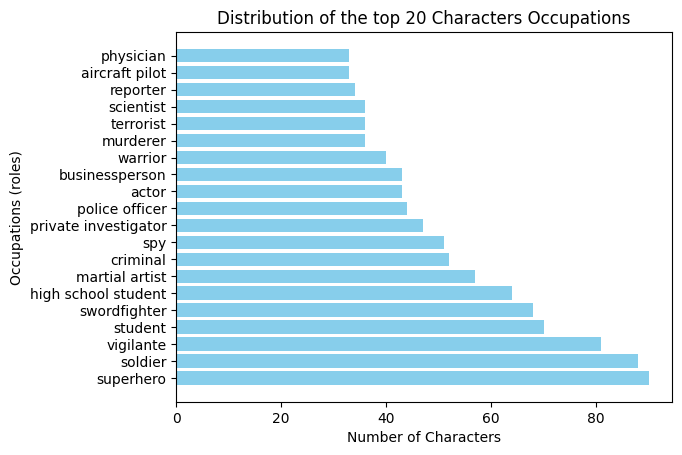

In [29]:
# convert character's occupations(role) to list
character_wikidata['occupation'] = character_wikidata['occupation'].dropna().apply(ast.literal_eval)

# retrieve all the character's occupation and count their occurences
occupations_lst = [occupation for interOccupationLst in character_wikidata['occupation'].dropna() for occupation in interOccupationLst]
occupation_count = Counter(occupations_lst)

# create a dataframe to create the graph
df_character_occupation = pd.DataFrame(occupation_count.items(), columns=['Occupation', 'Count'])
# sortby count and only select the first 20 items for readibility of the graph
df_character_occupation = df_character_occupation.sort_values(by='Count', ascending=False).head(20)

# constrcut the graph 
plt.barh(df_character_occupation['Occupation'], df_character_occupation['Count'], color='skyblue')
plt.xlabel('Number of Characters')
plt.ylabel('Occupations (roles)')
plt.title('Distribution of the top 20 Characters Occupations')
plt.show()

## Q2

### Family environment

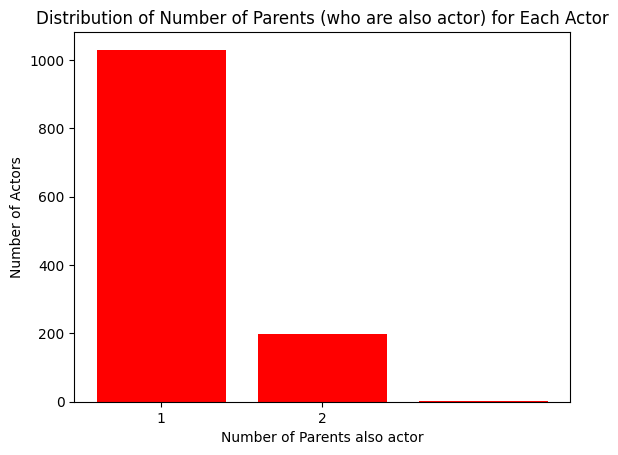

In [30]:
# transform the string of the columns of chiuldren and spouses into array.
actor_wikidata['spouse'] = actor_wikidata['spouse'].apply(ast.literal_eval)
actor_wikidata['children'] = actor_wikidata['children'].apply(ast.literal_eval)

# construct the object retrive to find the parent list of each actor.
from src.utils.retrieve_parents_from_children import ParentsFromChildrenRetriever
parentRetriever = ParentsFromChildrenRetriever(actor_wikidata=actor_wikidata)

# for each actor, retrieve the list of parents (who are also actor)
actor_wikidata['parents'] = actor_wikidata['actorLabel'].apply(parentRetriever.find_parents_for_child_actor_name)

# Visualize the results

# calculate the number of parent (who are also actor) for each actor 
actor_wikidata['number_actor_parents'] = actor_wikidata['parents'].apply(len)
number_of_parents = actor_wikidata['number_actor_parents'].value_counts().sort_index()
# only take into account the actor with at least one parent
number_of_parents = number_of_parents[number_of_parents.index > 0]

plt.bar(number_of_parents.index, number_of_parents.values, color='red')
plt.title('Distribution of Number of Parents (who are also actor) for Each Actor')
plt.xlabel('Number of Parents also actor')
plt.ylabel('Number of Actors')
plt.xticks([1,2])
plt.show()


We can observe that a significant number of actors have one (or occasionally two) parents working in the cinematographic field. By using the results of Q2 and Q3, we aim to determine whether having a parent in the cinematographic field, particularly one with a successful career, might influence an actor's own career success.

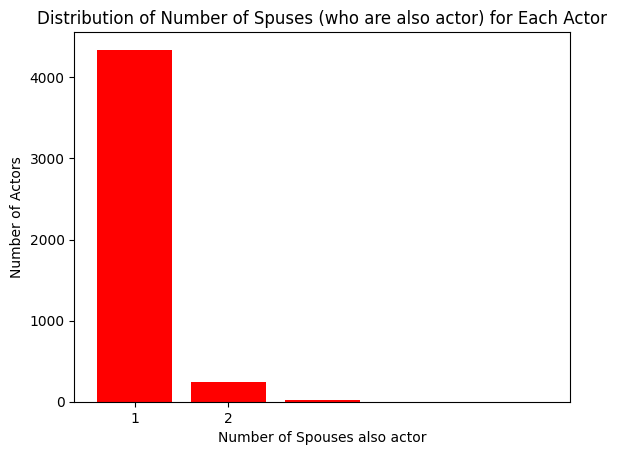

In [31]:
# calculate for each actor the number of spouses which is alos an actor
actor_wikidata['number_spouse_also_actor'] = actor_wikidata['spouse'].apply(lambda spouseLst: sum(1 for elem in spouseLst if elem in actor_wikidata['actorLabel'].values))

# visualize the results
number_of_spouses = actor_wikidata['number_spouse_also_actor'].value_counts().sort_index()
# only take into account the actor with at one souse as actor
number_of_spouses = number_of_spouses[number_of_spouses.index > 0]

plt.bar(number_of_spouses.index, number_of_spouses.values, color='red')
plt.title('Distribution of Number of Spuses (who are also actor) for Each Actor')
plt.xlabel('Number of Spouses also actor')
plt.ylabel('Number of Actors')
plt.xticks([1,2])
plt.show()


We can observe that a significant number of actors have spouses working in the cinematographic field. By comparing the results of Q2 and Q3, we aim to determine whether having a spouse in the cinematographic field, particularly one with a successful career, mightalso influence an actor's own career success.

### Academic background

8659


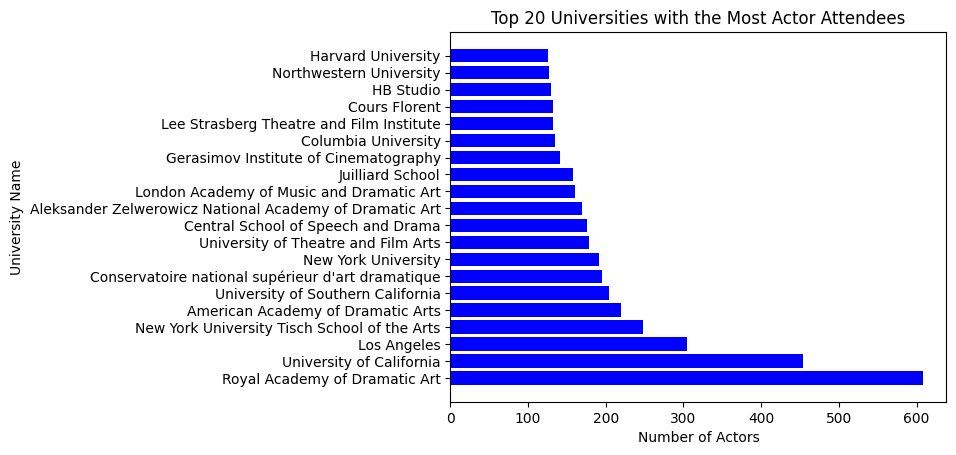

In [32]:
# flatten the list of all universities present on each actor row
universitiesLst = [university for actorUniversityLst in actor_wikidata['alma_mater'].apply(ast.literal_eval) for university in set(actorUniversityLst)] # make each university unique for each actor

# count the occurence of each university
universityCount = Counter(universitiesLst)

print(len(universityCount))

# visualize the results
df_university_count = pd.DataFrame(universityCount.items(), columns=['university_name', 'number_of_actors'])
# sort the results and select only the top 20
df_university_count = df_university_count.sort_values(by=['number_of_actors'], ascending=False).head(20)

plt.barh(df_university_count['university_name'], df_university_count['number_of_actors'], color='blue')
plt.xlabel('Number of Actors')
plt.ylabel('University Name')
plt.title('Top 20 Universities with the Most Actor Attendees')
plt.show()


We can observe that many actors have attended university. By linking this with the results of Q2 and Q3, we will be able to determine if a significant number of successful actors have attended the same university and, finally, whether a particular university is known for producing successful actors.

### Nationality


In [33]:
joined_df[joined_df['Movie countries'].apply(lambda x: len(x) >= 3)].head(100)

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID,Movie name,Movie release date,Movie countries,Movie genres
321,/m/052172r,Eva,1986,F,Mischa Barton,25,/m/0gy6lpr,/m/01qn8k,Bhopal: Prayer for Rain,2012,"[India, United States, United Kingdom]","[Disaster, Drama]"
322,/m/052172r,Dilip,1971,M,Rajpal Yadav,40,/m/0h5hc02,/m/05qtcv,Bhopal: Prayer for Rain,2012,"[India, United States, United Kingdom]","[Disaster, Drama]"
323,/m/052172r,Motwani,1977,M,Kal Penn,34,/m/0h2bj38,/m/03l3ln,Bhopal: Prayer for Rain,2012,"[India, United States, United Kingdom]","[Disaster, Drama]"
324,/m/052172r,Leela,<NA>,F,Tannishtha Chatterjee,<NA>,/m/0h75d8f,/m/04gl1d0,Bhopal: Prayer for Rain,2012,"[India, United States, United Kingdom]","[Disaster, Drama]"
325,/m/052172r,Warren Anderson,1940,M,Martin Sheen,71,/m/0h0hqh4,/m/0hvb2,Bhopal: Prayer for Rain,2012,"[India, United States, United Kingdom]","[Disaster, Drama]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1894,/m/04xzt0,NaN,1959,M,Peter Mullan,40,NaN,/m/090r4b,Ordinary Decent Criminal,2000,"[United States, Ireland, Germany, United Kingdom]","[Crime Fiction, Thriller, Film à clef, Crime D..."
1895,/m/04xzt0,Peter,1956,M,Christoph Waltz,43,/m/0h2scms,/m/026rm_y,Ordinary Decent Criminal,2000,"[United States, Ireland, Germany, United Kingdom]","[Crime Fiction, Thriller, Film à clef, Crime D..."
1896,/m/04xzt0,NaN,1965,M,Paul Ronan,34,NaN,/m/09k7kjz,Ordinary Decent Criminal,2000,"[United States, Ireland, Germany, United Kingdom]","[Crime Fiction, Thriller, Film à clef, Crime D..."
1897,/m/04xzt0,NaN,1929,M,David Kelly,70,NaN,/m/0720dt,Ordinary Decent Criminal,2000,"[United States, Ireland, Germany, United Kingdom]","[Crime Fiction, Thriller, Film à clef, Crime D..."
